In [1]:
# installing requirements, uncomment and run if needed!
#!pip -q install ./python

### Imports

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent
from unityagents import UnityEnvironment

import time


In [3]:
AVG_SOL_REWARD = 0.5     # over the window of 100 episode, the min average reward to stop

### Creating the environment and exploring its details
make sure to point it to the unzipped file on your machine

In [4]:
env = UnityEnvironment(file_name='/data/Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Creating the Agent

In [7]:
agent = Agent(state_size=48, action_size=4, random_seed=13)

### The training Loop

In [8]:
def ddpg(n_episodes=10000, print_every=100):
    start = time.time()
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations.flatten()
        agent.reset()
        score = [0,0]
        while True:
            actions = agent.act(np.expand_dims(states,axis=0))
            #print('actions.shape: ',actions.shape)
            env_info = env.step(actions.reshape(2,-1))[brain_name]     # send the actions to the environment
            next_states = env_info.vector_observations.flatten()       # get the next states
            #print('next_states.shape: ',next_states.shape)
            rewards = env_info.rewards                                # get the rewards
            done = max(env_info.local_done)                             # see if episode has finished
            
            agent.step(states, actions, max(rewards), next_states, done)
            #print('reward:' ,rewards)
            states = next_states
            score[0] += rewards[0]
            score[1] += rewards[1]
            if done:
                break 
        score = max(score)
        scores_deque.append(score)
        scores.append(score)
        past100Score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, past100Score), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, past100Score))
        
        if len(scores_deque)>=100 and past100Score >= AVG_SOL_REWARD:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, past100Score))
            torch.save(agent.actor_local.state_dict(), 'trained_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'trained_critic.pth')
            break
    end = time.time()
    print("Training time: ", end - start) 
    return scores

scores = ddpg()



Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.04
Episode 400	Average Score: 0.06
Episode 500	Average Score: 0.10
Episode 600	Average Score: 0.11
Episode 700	Average Score: 0.09
Episode 800	Average Score: 0.18
Episode 900	Average Score: 0.27
Episode 944	Average Score: 0.51
Environment solved in 944 episodes!	Average Score: 0.51
Training time:  492.80202460289


In [9]:
torch.save(agent.actor_local.state_dict(), 'trained_actor.pth')
torch.save(agent.critic_local.state_dict(), 'trained_critic.pth')

### Plotting the scores

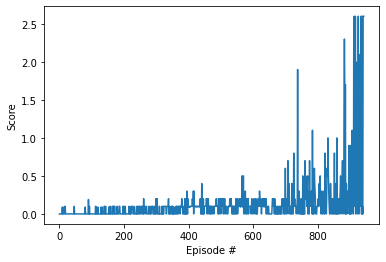

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()